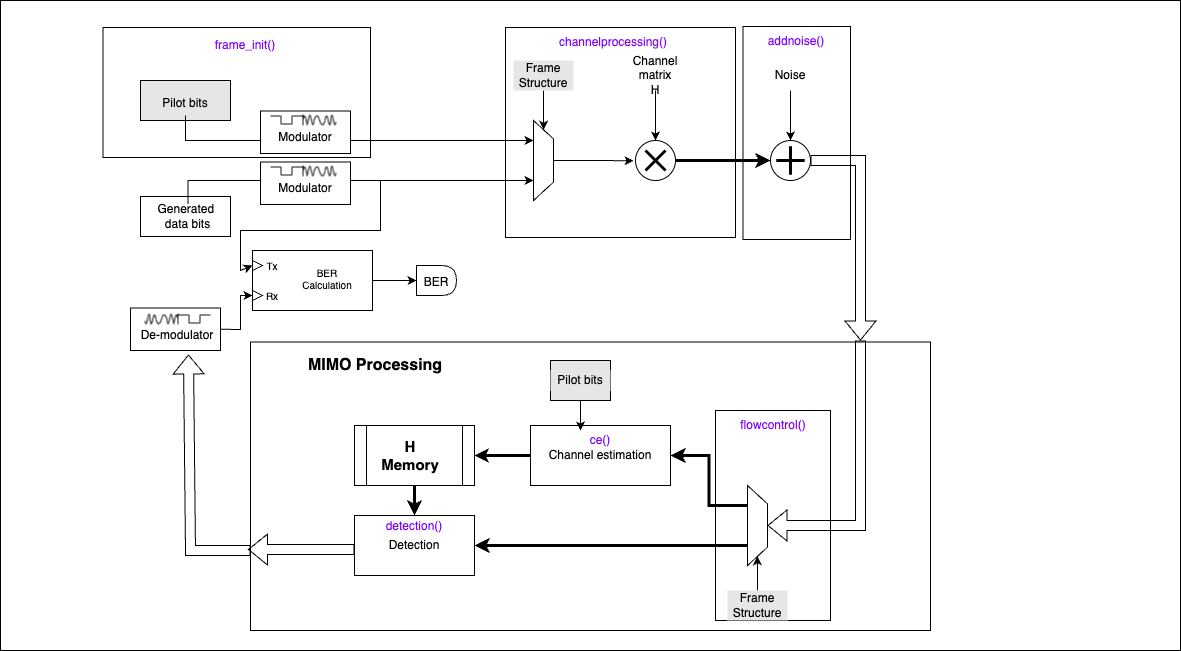

This is a generic massive MIMO processing simulator.


Algorithms supported:
1. MRC
2. Zero forcing using Cholesky decomposition
3. Sphere decoding based on ZF result

Reconfigurable parameters:
1. massive MIMO setups
2. Frame schedule
3. Modulation schmes when using linear detection algorithms
4. Search radius for sphere decoding

In [1]:
import numpy as np
import enum
from fxpmath import Fxp
import cmath
import math
import commpy as cpy
import matplotlib.pyplot as plot
import scipy.io
import itertools
from itertools import permutations
%run functions.ipynb

In [2]:
    frameNr=40
    SNR_array = np.arange(0,40,1)
    
    alg  = "ZF"
    radius = [2,2,4,4]#needed for SD
    M=32
    K=4
    Nsub=600
    N_point =1024
    Concurrence = 1


    frameSchedule = [OFDMSymbolType.ULP, OFDMSymbolType.ULD, OFDMSymbolType.ULD, OFDMSymbolType.GUARD, 
                  OFDMSymbolType.DLP, OFDMSymbolType.DLD, OFDMSymbolType.DLD]
    NrULD=frameSchedule.count(OFDMSymbolType.ULD)
    pilots_bits = np.random.binomial(n=1,p=0.5,size=(Nsub//(K*Concurrence),K*2))

    qam = cpy.QAMModem(16)
    %run setup.ipynb


In [3]:
#load channel data
mat = scipy.io.loadmat('matlab.mat')#
H_norm = normlization(mat)

In [4]:
# system specification
def frame_init():
    global qpsk
    global pilots_symbol
    global pilots_lut
    global pilots_bits
    global H_gen
    global data_bits_a,data_bits_b,data_symbol_a,data_symbol_b
    pilots_symbol = np.zeros((Nsub//(K*Concurrence),K),dtype=complex)
    qpsk = cpy.QAMModem(4)
    for i in range(0,Nsub//(K*Concurrence)):
        pilots_symbol[i,:]=np.array(qpsk.modulate(pilots_bits[i,:])/math.sqrt(2))
    pilots_symbol = np.pad(pilots_symbol,[(0,0),(0,K*(Concurrence-1))],mode='constant',constant_values=0+0j).reshape(Nsub)
    pilots_lut = pilots_symbol
    for i in range(0,Nsub//(K*Concurrence)):      
        H_gen[i] = H_norm[i*K*Concurrence,:,:]
    

In [5]:
def channelprocessing():
    global H_gen
    global OFDMSymbolCounter_gen
    global SubcarrierCounter_gen
    global pilots_symbol
    inputVector = np.zeros((M,1),dtype=complex)
    dataVector = np.zeros((K,1),dtype=complex)
    if SubcarrierCounter_gen == Nsub:
        OFDMSymbolCounter_gen = OFDMSymbolCounter_gen + 1
        if OFDMSymbolCounter_gen == len(frameSchedule):
            OFDMSymbolCounter_gen = 0
        SubcarrierCounter_gen = 0
    currentSymbolType_gen = frameSchedule[OFDMSymbolCounter_gen]
    H_use = H_norm[SubcarrierCounter_gen,:,:]
    if currentSymbolType_gen == OFDMSymbolType.ULP:
        pilotVector = np.zeros((K,1),dtype=complex)
        pilotVector[SubcarrierCounter_gen % K,0] = pilots_symbol[SubcarrierCounter_gen]
        inputVector = np.dot(H_use,pilotVector)
    if currentSymbolType_gen == OFDMSymbolType.ULD:
        dataVector[:,0] = data_symbol[:,SubcarrierCounter_gen+Nsub*(OFDMSymbolCounter_gen-1)]
        inputVector = np.dot(H_use,dataVector)       
    SubcarrierCounter_gen = SubcarrierCounter_gen + 1
    return inputVector

    

In [6]:
def flowcontrol(inputVector):
    global OFDMSymbolCounter
    global SubcarrierCounter
    global currentSymbolType
    currentSymbolType = frameSchedule[OFDMSymbolCounter]
    tmpSubcarrierCounter = SubcarrierCounter
    SubcarrierCounter = SubcarrierCounter + 1
    if SubcarrierCounter == Nsub:
        SubcarrierCounter = 0
        OFDMSymbolCounter = OFDMSymbolCounter + 1
        if OFDMSymbolCounter == len(frameSchedule):
            OFDMSymbolCounter = 0
    return tmpSubcarrierCounter, currentSymbolType

In [7]:
def ce(inputVector, tmpSubcarrierCounter, currentSymbolType):
    
    global detMatrixCounterStore
    global HMatrixCounterStore
    global Hest
    global pilots_lut
    global detMatrixMemory
    if currentSymbolType == OFDMSymbolType.ULP:
        subcarriersModUsers = tmpSubcarrierCounter % (K*Concurrence)
        if subcarriersModUsers < K:
            for i in range(0,M):
                tmpPilot = pilots_lut[tmpSubcarrierCounter];
                Hest[i, subcarriersModUsers] = inputVector[i]*(tmpPilot.conj());
                
        #write to memory
        if subcarriersModUsers == K-1:
            
            for cols in range(0, K):
                for rows in range(0,M):
                    HMemory[HMatrixCounterStore*K+cols,rows] = Hest[rows,cols]

            HMatrixCounterStore = HMatrixCounterStore +1

            if HMatrixCounterStore == Nsub/(K*Concurrence):
                HMatrixCounterStore = 0    
    

In [8]:
def freq2time():
    
    freqDomain=np.zeros((M,N_point),dtype=complex)
    for i in range(0,Nsub):
        inputVector1 = channelprocessing()
        inputVector_n=addnoise(inputVector1,frameSchedule[OFDMSymbolCounter_gen],target_snr_db)

        indice = N_point//2-Nsub//2+i
        if i< Nsub//2:
            freqDomain[:,indice] = inputVector_n.ravel()

        else:
            freqDomain[:,indice+1] = inputVector_n.ravel()
       
    timeDomain = np.fft.ifft(freqDomain,axis=1)
    for i in range(0,N_point//2):
        timeDomain[:,2*i]=-1*timeDomain[:,2*i]
     
    return timeDomain

In [9]:
def time2freq(timeDomain):
    global data_symbol2
    global ULDCounter
    for i in range(0,N_point//2):
        timeDomain[:,2*i]=-1*timeDomain[:,2*i]
    freqDomain2=np.fft.fft(timeDomain,axis=1)
    for i in range(0,Nsub):
        indice = (i+N_point//2-Nsub//2)
        if i < Nsub/2:
            inputVector = freqDomain2[:,[indice]]
        else:
            inputVector = freqDomain2[:,[indice+1]]
        [tmpSubcarrierCounter, currentSymbolType] = flowcontrol(inputVector)
        ce(inputVector,tmpSubcarrierCounter, currentSymbolType)
        detectedVector = detection(inputVector,tmpSubcarrierCounter, currentSymbolType)
        if currentSymbolType == OFDMSymbolType.ULD:
            data_symbol2[:,[i+ULDCounter*Nsub]] = detectedVector
    if currentSymbolType == OFDMSymbolType.ULD:
        ULDCounter = (ULDCounter+1)%NrULD
    return data_symbol2

In [10]:
def detection(inputVector, tmpSubcarrierCounter, currentSymbolType):
    global detMatrixCounterFetch
    global HMatrixCounterFetch
    if currentSymbolType == OFDMSymbolType.ULD:
        subcarriersModUsers = tmpSubcarrierCounter % K
        detMatrix = np.array([[0+0j for _ in range(M)] for _ in range(K)])
        HestMatrix = np.array([[0+0j for _ in range(K)] for _ in range(M)])
        possibleSymbol = np.array([[0+0j for _ in range(16)] for _ in range(K)])
        G = np.array([[0+0j for _ in range(K)] for _ in range(K)])
        Ginv = np.array([[0+0j for _ in range(K)] for _ in range(K)])
        HestHermitian = np.array([[0+0j for _ in range(M)] for _ in range(K)])
        
        #read from memory
        for cols in range(0,K):
            for rows in range(0,M):
                HestMatrix[rows,cols] = HMemory[HMatrixCounterFetch*K+cols, rows]

        HMatrixCounterFetch = math.floor((tmpSubcarrierCounter+1)/(K*Concurrence))
        

        if HMatrixCounterFetch == Nsub/(K*Concurrence):
            HMatrixCounterFetch = 0
        
        for cols in range(0,K):
            for rows in range(0,M):
                HestHermitian[cols,rows] = HestMatrix[rows,cols].conj()

        match alg:
            case "ZF":
                G = np.dot(HestHermitian, HestMatrix)
                Ginv = np.linalg.inv(G)
                detMatrix = np.dot(Ginv, HestHermitian)
                detectedVector = np.dot(detMatrix,inputVector)
            case "SD":
                G = np.dot(HestHermitian, HestMatrix)
                Ginv = np.linalg.inv(G)
                detMatrix = np.dot(Ginv, HestHermitian)
                detectedVector1 = np.dot(detMatrix,inputVector)
                for i in range(0,K):
                    possibleSymbol[i,:]= findNearest(detectedVector1[i],4,10)
                detectedVector = findNearestVector(inputVector,possibleSymbol,HestMatrix).reshape(K,1)
            case _:
                detectedVector = np.dot(HestHermitian,inputVector)

         
        return detectedVector

In [11]:

BER_array = np.zeros((len(SNR_array),K))
frameFactor = frameNr//len(SNR_array)
num_bit_errors = np.zeros(K)
acc_num_bit_errors = np.zeros(K)
frame_init()

data_symbol2 = np.zeros((K,Nsub*NrULD),dtype=complex)

for j in range(0,frameNr):

    
    target_snr_db =  SNR_array[j//frameFactor]#noise level for this frame
    data_bits = np.random.binomial(n=1,p=0.5,size = (Nsub*K*4*NrULD))
    data_symbol = np.array(qam.modulate(data_bits)/math.sqrt(10)).reshape(K,Nsub*NrULD)


    data_bits = data_bits.reshape(K,4*Nsub*NrULD)
    data_bits2 = np.zeros((K,Nsub*4*NrULD),dtype = int)


    for i in range(0,len(frameSchedule)): 
        timeDomain = freq2time();
        data_symbol2 = time2freq(timeDomain)
    for k in range(0,K):
        data_bits2[k,:] = qam.demodulate(data_symbol2[k,:]*math.sqrt(10),'hard')
        num_bit_errors[k]= cpy.utilities.hamming_dist(data_bits[k,:],data_bits2[k,:])
        acc_num_bit_errors[k] = acc_num_bit_errors[k] + num_bit_errors[k]
        
    if (j+1)%frameFactor == 0:
        BER_array[j//frameFactor] = K*acc_num_bit_errors/data_bits.size

        acc_num_bit_errors = np.zeros(K)



Text(0, 0.5, 'BER')

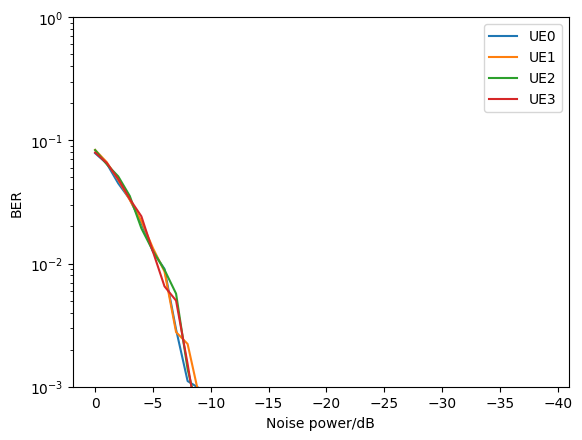

In [12]:
ax = plot.gca()
ax.invert_xaxis()
plot.semilogy(-SNR_array,BER_array[:,0],label="UE0")
plot.semilogy(-SNR_array,BER_array[:,1],label="UE1")
plot.semilogy(-SNR_array,BER_array[:,2],label="UE2")
plot.semilogy(-SNR_array,BER_array[:,3],label="UE3")

plot.ylim([0.001,1])
plot.legend(loc="best")
plot.xlabel("Noise power/dB")
plot.ylabel("BER")
